In [9]:
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [39]:
# io=pd.read_csv('../../data/US_windfarm/us-windfarm/IO.csv')
us=pd.read_csv('../../data/US_windfarm/us-windfarm/US.csv')

In [6]:
io.loc[:,['xlong','ylat']]

,xlong,ylat
0,-93.523651,42.006813
1,-93.632835,41.882477
2,-93.515892,42.016373
3,-92.672089,41.742046
4,-93.513710,42.019119
...,...,...
5406,-93.547928,41.792606
5407,-93.738007,41.708420
5408,-95.857811,41.290985
5409,-90.616096,41.622890


In [31]:
clustering005 = DBSCAN(eps=0.05, min_samples=5).fit(io.loc[:,['xlong','ylat']])
clustering01 = DBSCAN(eps=0.1, min_samples=5).fit(io.loc[:,['xlong','ylat']])

In [40]:
clusteringus = DBSCAN(eps=0.1, min_samples=5).fit(us.loc[:,['xlong','ylat']])

In [65]:
np.unique(clusteringus.labels_).shape

(420,)

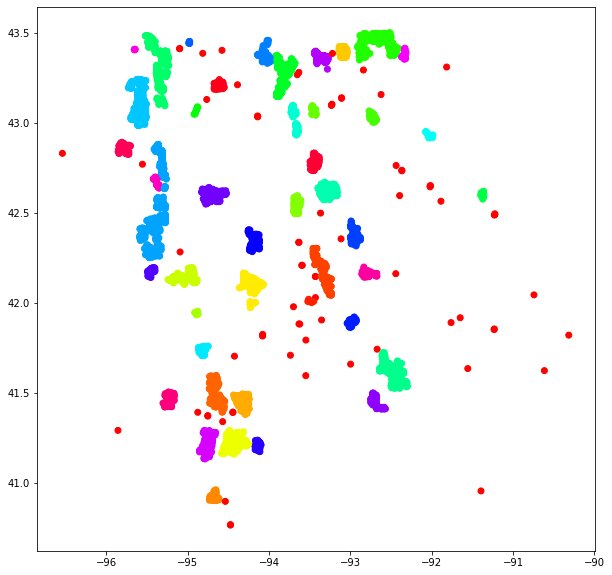

In [37]:
fig, ax=plt.subplots(1,figsize=(10,10))
ax.scatter(x=io['xlong'],y=io['ylat'],c=clustering005.labels_,cmap='hsv')

(20, 50)

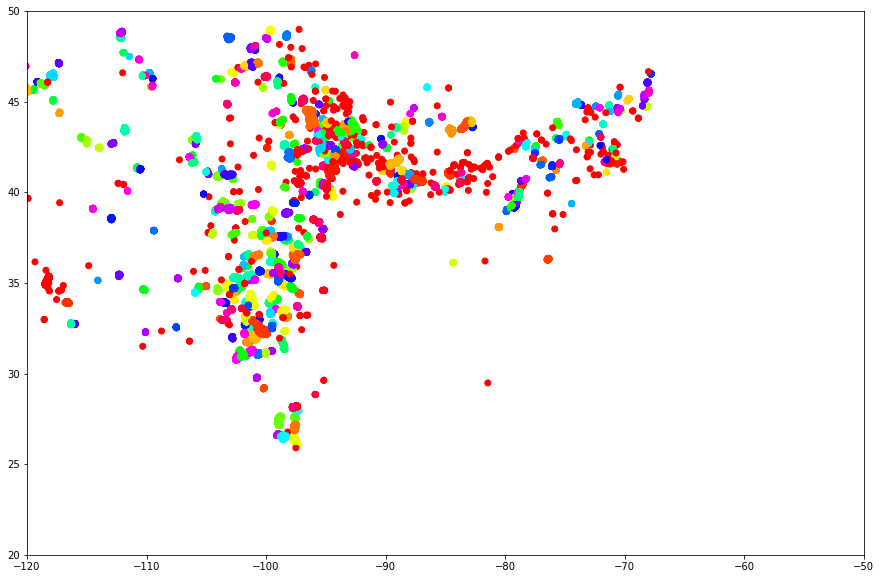

In [64]:
fig, ax=plt.subplots(1,figsize=(15,10))
# ind=(us['xlong']>-97) & (us['xlong']<-90) & (us['ylat']>40) & (us['ylat']<44) 
# ax.scatter(x=us.loc[ind,'xlong'],y=us.loc[ind,'ylat'],c=clusteringus.labels_[ind],cmap='hsv')

ax.scatter(x=us['xlong'],y=us['ylat'],c=clusteringus.labels_,cmap='hsv')

ax.set_xlim([-120,-50])
ax.set_ylim([20,50])

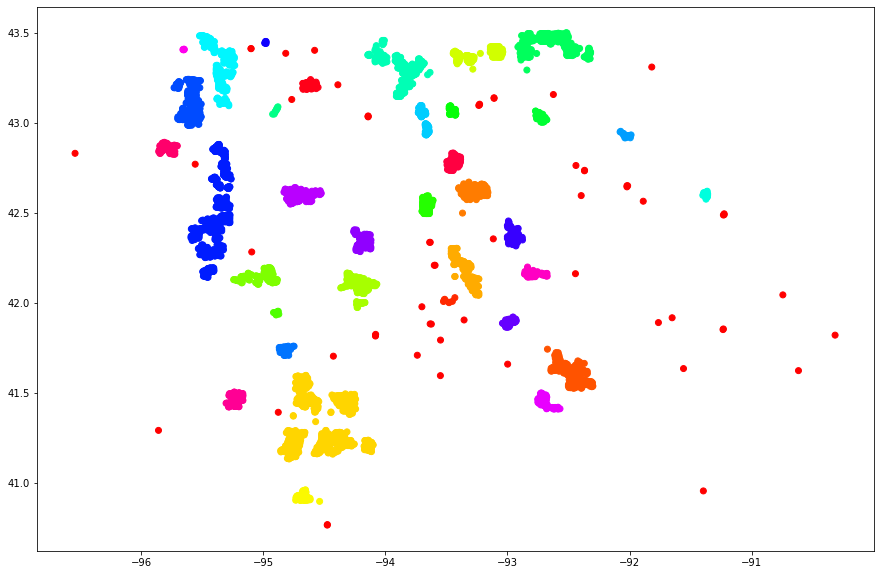

In [63]:
fig, ax=plt.subplots(1,figsize=(15,10))
ax.scatter(x=io['xlong'],y=io['ylat'],c=clustering01.labels_,cmap='hsv')

In [22]:
%matplotlib inline

In [24]:
plt.scatter?

In [8]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from geopandas import GeoDataFrame
from pandas import Series,DataFrame
import shapefile as shp
import pandas as pd

In [44]:
# 读取shp并转换成矩阵
wf_data =GeoDataFrame.from_file('E:/美国风电/数据/us-windfarm - 副本 - 副本/uswtdb_v2_3_20200109.shp')
X=wf_data.geometry.x
Y=wf_data.geometry.y
XX=np.array(X)
YY=np.array(Y)
z = list(zip(XX,YY))
zz=np.array(z)

In [110]:
# #############################################################################
# 调用密度聚类  DBSCAN
db = DBSCAN(eps=0.4, min_samples=5).fit(zz)
# print(db.labels_)  # db.labels_为所有样本的聚类索引，没有聚类索引为-1
# print(db.core_sample_indices_) # 所有核心样本的索引
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)  # 设置一个样本个数长度的全false向量
core_samples_mask[db.core_sample_indices_] = True #将核心样本部分设置为true
labels = db.labels_
# 获取聚类个数。（聚类结果中-1表示没有聚类为离散点）
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('估计的聚类个数为: %d' % n_clusters_)

估计的聚类个数为: 194


In [109]:
cluster_total=np.c_[labels]
cluster=pd.DataFrame(cluster_total)
cluster.to_csv("E:/US/db_0.4_5.csv")

In [82]:
##测试不同参数组合
# 构建空列表，用于保存不同参数组合下的结果
res = []
lab=[]
# 迭代不同的eps值
for eps in np.arange(0.001,1,0.1):
    # 迭代不同的min_samples值
    for min_samples in range(1,10):
        dbscan = DBSCAN(eps = eps, min_samples = min_samples)
        # 模型拟合
        dbscan.fit(zz)
        # 统计各参数组合下的聚类个数（-1表示异常点）
        n_clusters = len([i for i in set(dbscan.labels_) if i != -1])
        # 异常点的个数
        outliners = np.sum(np.where(dbscan.labels_ == -1, 1,0))
        # 统计每个簇的样本个数
        labels_loop = db.labels_
        stats = str(pd.Series([i for i in dbscan.labels_ if i != -1]).value_counts().values)
        res.append({'eps':eps,'min_samples':min_samples,'n_clusters':n_clusters,'outliners':outliners,'stats':stats})
        cluster_db=np.c_[labels_loop]
        lab.append(labels_loop)
# 将迭代后的结果存储到数据框中        
df = pd.DataFrame(res)

# 根据条件筛选合理的参数组合
df.loc[df.n_clusters == 3, :]

,eps,min_samples,n_clusters,outliners,stats


In [94]:
lab0=np.array(lab)
lab0=lab0.T
cluster_dbscan=pd.DataFrame(lab0)
cluster_dbscan.to_csv("E:/US/dbscan_list3.csv")

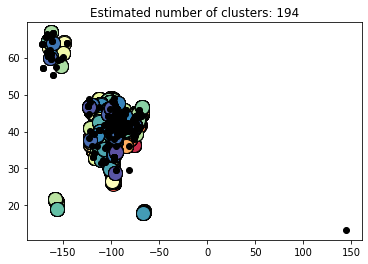

In [111]:
 #############################################################################
# Plot result
import matplotlib.pyplot as plt

# 使用黑色标注离散点
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:  # 聚类结果为-1的样本为离散点
        # 使用黑色绘制离散点
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)  # 将所有属于该聚类的样本位置置为true

    xy = zz[class_member_mask & core_samples_mask]  # 将所有属于该类的核心样本取出，使用大图标绘制
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),markeredgecolor='k', markersize=14)

    xy = zz[class_member_mask & ~core_samples_mask]  # 将所有属于该类的非核心样本取出，使用小图标绘制
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()